[Sign language competition:](https://www.kaggle.com/competitions/asl-signs)
* `Landmark Data`: A set of labeled landmark data extracted from raw videos using the MediaPipe Holistic Solution. This dataset is used to train machine learning models for isolated American Sign Language recognition in the competition.
  * A set of points on an object that are used to determine its shape, orientation, and location in space.
  * 
* `TensorFlow Lite`: A lightweight and cross-platform framework for deploying machine learning models on mobile and embedded devices. It enables on-device machine learning inference with low latency and a small binary size.

Reference


* https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#introduction
  * ASL is a visual-gestural language, meaning that it uses facial expressions, body language, and hand movements to convey meaning.
  * ISOLATED SIGN LANGUAGE RECOGNITION: the process of recognizing sign language gestures performed by a person in isolation, without considering the context or the surrounding gestures.


# 1 Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Import package

In [2]:
! pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=5a3ac9cede0329ce16d5d9d2b92cb37d1acec132d15412178cfc9e6c7c5ed99a
  Stored in directory: /root/.cache/pip/wheels/41/01/29/deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel


In [3]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 32.3 MB/s eta 0:00:00


In [4]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from glob import glob
import os

import json
import pandas as pd
import numpy as np
from pandarallel import pandarallel
from tqdm.notebook import tqdm; tqdm.pandas();

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import tensorflow as tf
import tensorflow_addons as tfa
import math

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
# configuration

seed = 2023
train_test_ratio = 0.2

## 1.2 Load data from Kaggle

In [13]:
# import kaggle data
'''
step 1: download token from kaggle
step 2: click "join" competition
step 3: upload kaggle.json inside file
'''

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
# download the file (takes time)
! kaggle competitions download -c asl-signs

100% 37.4G/37.4G [32:25<00:00, 21.8MB/s]
100% 37.4G/37.4G [32:25<00:00, 20.6MB/s]


In [15]:
# unzip selected training files
%%capture

! unzip asl-signs.zip train_landmark_files/16069/*.parquet
! unzip asl-signs.zip train_landmark_files/18796/*.parquet
! unzip asl-signs.zip train_landmark_files/2044/*.parquet
! unzip asl-signs.zip train_landmark_files/22343/*.parquet
! unzip asl-signs.zip train_landmark_files/25571/*.parquet

In [16]:
! unzip asl-signs.zip sign_to_prediction_index_map.json

Archive:  asl-signs.zip
  inflating: sign_to_prediction_index_map.json  


In [12]:
! unzip train.csv.zip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


## 1.3 Load data files
There are 3 input files:
* `train.csv`: each row is a vocab
* `*.parquet`: each parquet file is frame-body-coordinate level to illustrate a word
* `sign_to_prediction_index_map.json`: translate vocab to index (for model training)

In [13]:
# 1.3.1 load train.csv
train_df = pd.read_csv('train.csv',error_bad_lines=False)
print('Original shape: ', train_df.shape)

# keep path to selected files
file_list = ['train_landmark_files/16069', 'train_landmark_files/18796', 'train_landmark_files/2044', 'train_landmark_files/22343', 'train_landmark_files/25571']
train_df = train_df[train_df['path'].str.contains('|'.join(file_list))]
print('Subset shape', train_df.shape)

Original shape:  (94477, 4)
Subset shape (21702, 4)


<ipython-input-13-5be46e42edfd>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_df = pd.read_csv('train.csv',error_bad_lines=False)


In [14]:
# 1.3.2 load sign name to index map json
def read_json_file(file_path):
    """
    Returns a dictionary object representing the JSON data.
    """
    # Open the file and load the JSON data into a Python object
    with open(file_path, 'r') as file:
        json_data = json.load(file)
    return json_data
        

# encoder
s2p_map = {k.lower():v for k,v in read_json_file("sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())

# decoder
p2s_map = {v:k for k,v in read_json_file("sign_to_prediction_index_map.json").items()}
decoder = lambda x: p2s_map.get(x)

In [15]:
# apply encoder
train_df['sign_ord'] = train_df['sign'].apply(encoder)

# 2 EDA

## 2.1 train_df EDA

In [16]:
train_df

,path,participant_id,sequence_id,sign,sign_ord
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
12,train_landmark_files/22343/1000638205.parquet,22343,1000638205,puzzle,180
20,train_landmark_files/22343/1001223069.parquet,22343,1001223069,not,156
25,train_landmark_files/18796/1001373962.parquet,18796,1001373962,have,108
...,...,...,...,...,...
94442,train_landmark_files/2044/998713046.parquet,2044,998713046,fine,79
94450,train_landmark_files/22343/999026579.parquet,22343,999026579,face,73
94463,train_landmark_files/22343/999330838.parquet,22343,999330838,pretty,178
94471,train_landmark_files/25571/999740509.parquet,25571,999740509,scissors,192


In [22]:
# 2.1.1 TARGET: `sign` column
display(train_df["sign"].describe().to_frame().T)

fig = px.histogram(train_df
                   , y=train_df["sign"]
                   , color="sign"
                   , orientation="h"
                   , height=5000
                   , labels={"y":"<b>Sign (label)</b>", "count":"<b>Total Row Count</b>"}
                   , title="<b>Row Counts by Sign (label)</b>"
                   , category_orders={"sign": train_df["sign"].value_counts().index}
)
fig.update_yaxes(title_text="<b>Total Row Count</b>")
fig.update_layout(showlegend=False)
fig.show()

,count,unique,top,freq
sign,21702,250,duck,105


## 2.2 Parquet EDA

### 2.2.1. Full dataset EDA
* build train_extended to extract metadata from parquet files

In [23]:
# 2.2.1 body type missing value

# build meta feature
def get_seq_meta(row):
    # count values in parquet files
    df = get_sign_df(row['path'], invert_y=True)
    type_counts = df['type'].value_counts(dropna=False).to_dict()
    nan_counts  = df.groupby("type")["x"].apply(lambda x: x.isna().sum())

    # append frame data in train_df
    row['start_frame'] = df['frame'].min()
    row['end_frame'] = df['frame'].max()
    row['total_frames'] = df['frame'].nunique()

    # append count values in train_df
    for i in ["face", "pose", "left_hand", "right_hand"]:
        row[f'{i}_count'] = type_counts[i]
        row[f'{i}_nan_count'] = nan_counts[i]

    # append max & min coordicates in train_df
    for coord in ['x', 'y', 'z']:
        row[f'{coord}_min'] = df[coord].min()
        row[f'{coord}_max'] = df[coord].max()

    return row

In [24]:
# %%time

# pandarallel.initialize(progress_bar=True)

# extended_train_df = train_df.parallel_apply(lambda x: get_seq_meta(x), axis=1)
# extended_train_df.to_csv('extended_train_df.csv')

In [25]:
# %cd /content/drive/MyDrive/NUS_MSBA/BT5153/group project
# extended_train_df = pd.read_csv('extended_train_df.csv')

In [26]:
# extended_train_df

NameError: ignored

In [ ]:
# # Compute the appearance and NaN percentages
# type_kp_map = dict(face=468, left_hand=21, pose=33, right_hand=21)

# for _type, _count in tqdm(type_kp_map.items(), desc="Computing percentages"):
#     extended_train_df[f"{_type}_appears_pct"] = extended_train_df[f"{_type}_count"] / (extended_train_df["total_frames"] * _count)
#     extended_train_df[f"{_type}_nan_pct"] = extended_train_df[f"{_type}_nan_count"] / (extended_train_df["total_frames"] * _count)

# # Plot the frequency (log scale) of the number of samples in the dataset that have a given percentage of NaN values v.s. percentage of data points that are NaN
# def title_map_fn(ann):
#     title_map = {
#     'face_nan_pct': '<b>Percentage Of <i>Face</i> Data Points That Are NaN</b>', 
#     'left_hand_nan_pct': '<b>Percentage Of <i>Left Hand</i> Data Points That Are NaN</b>',
#     'pose_nan_pct': '<b>Percentage Of <i>Pose</i> Data Points That Are NaN</b>',
#     'right_hand_nan_pct': '<b>Percentage Of <i>Right Hand</i> Data Points That Are NaN</b>'}
#     ann.text = title_map.get(ann.text[1:])
    
# fig = px.histogram(extended_train_df
#                    , ["face_nan_pct", "left_hand_nan_pct", "pose_nan_pct", "right_hand_nan_pct"]
#                    , height=750
#                    , labels={'variable': '', 'count': '<b>Frequency (LOG)</b>', 'value':"<b>Percentage of Points That Are NaN</b>"}
#                    , log_y=True
#                    , facet_col='variable'
#                    , nbins=20
#                    , opacity=0.75
#                    , facet_col_wrap=2
#                    , facet_col_spacing=0.05)
# fig.update_yaxes(title_text='<b>Frequency (LOG)</b>', col=1)
# fig.for_each_annotation(title_map_fn)
# fig.update_layout(showlegend=False)
# fig.show()

### 2.2.3 Sample parquet EDA

In [27]:
# read a parquet file from a selected row in train.csv
def get_sign_df(pq_path, invert_y=True):
    sign_df = pd.read_parquet(pq_path)

    # y value is inverted, because of the video flipping
    if invert_y: sign_df["y"] *= -1 
        
    return sign_df

'''
Data structure:
- frame: each picture in the video
- row_id: each tracing point on body parts
- x, y, z: coordinate -- ignore z because mediaPipe model is not fully trained to predict depth
'''

selected_row = 100
demo_sign_df = get_sign_df(train_df.iloc[selected_row]["path"])
demo_sign_df

,frame,row_id,type,landmark_index,x,y,z
0,22,22-face-0,face,0,0.482337,-0.440157,-0.041068
1,22,22-face-1,face,1,0.486704,-0.407177,-0.057901
2,22,22-face-2,face,2,0.484998,-0.420724,-0.035808
3,22,22-face-3,face,3,0.470767,-0.380886,-0.037523
4,22,22-face-4,face,4,0.485586,-0.397479,-0.059235
...,...,...,...,...,...,...,...
8683,37,37-right_hand-16,right_hand,16,NaN,NaN,NaN
8684,37,37-right_hand-17,right_hand,17,NaN,NaN,NaN
8685,37,37-right_hand-18,right_hand,18,NaN,NaN,NaN
8686,37,37-right_hand-19,right_hand,19,NaN,NaN,NaN


In [28]:
# EDA on selected demo parque
print("Unique body parts: ", demo_sign_df['type'].unique())
demo_graph = demo_sign_df[['frame', 'type', 'x']].groupby(by=['frame', 'type']).count().reset_index()
demo_graph

Unique body parts:  ['face' 'left_hand' 'pose' 'right_hand']


,frame,type,x
0,22,face,468
1,22,left_hand,21
2,22,pose,33
3,22,right_hand,0
4,23,face,468
...,...,...,...
59,36,right_hand,0
60,37,face,468
61,37,left_hand,21
62,37,pose,33


In [29]:
# graph
fig = px.line(demo_graph, x='frame', y='x', color='type', hover_data=['frame', 'type', 'x'])

# Add a title to the plot
fig.update_layout(title='Number of keypoints (X) by frame and type')

fig.show()

'''
For each part of the body ('type') we have the following keypoint counts:
* `Right Hand` --> 21 Keypoints
* `Left Hand` --> 21 Keypoints (some can be missing, indicating that it is not a dominant hand)
* `Pose` --> 33 Keypoints
* `Face` --> 468 Keypoints
'''

"\nFor each part of the body ('type') we have the following keypoint counts:\n* `Right Hand` --> 21 Keypoints\n* `Left Hand` --> 21 Keypoints (some can be missing, indicating that it is not a dominant hand)\n* `Pose` --> 33 Keypoints\n* `Face` --> 468 Keypoints\n"

# 3 Baseline Model

## 3.1 Feature processing
* Baseline model: left hand and right hand

In [30]:
# Configuration

# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)

# Concated Landmart indices
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)

# Landmark indices in processed data
LEFT_HAND_IDXS = np.argwhere(LEFT_HAND_IDXS0).squeeze()
RIGHT_HAND_IDXS = np.argwhere(RIGHT_HAND_IDXS0).squeeze()
HAND_IDXS = np.argwhere(HAND_IDXS0).squeeze()

In [31]:
# define a function to load data
'''
output: n_frames, keypoints, [x,y]
'''

KEYPOINTS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y'] # z is irrelavant
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / KEYPOINTS_PER_FRAME)
    data = data.values.reshape(n_frames, KEYPOINTS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [32]:
N_ROWS = 543
N_DIMS = 2
DIM_NAMES = ['x', 'y']
INPUT_SIZE = 64 # TBC - downsize parameter to prevent video to be too long
N_COLS = 21 # dominant side index

# Tensorflow layer to process data in TFLite
'''
input: (batch_size, number of keypoints, [x,y] coordinates)
output1: (input_size, dominant side keypoints, [x,y] coordinates)
output2: (input_size)
'''
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()

        # tbc for model *******************************************************
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand)
                    [0.50] * len(LEFT_HAND_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LEFT_HAND_IDXS),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        # *********************************************************************

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
       
        # Filter out frames w/o dominant hand
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns: TBC ********************************
        if left_dominant:
            data = tf.gather(data, LEFT_HAND_IDXS0, axis=1)
        else:
            data = tf.gather(data, RIGHT_HAND_IDXS0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        # **********************************************************************
      
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [33]:
# load & process data
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [34]:
# input-output shape check
path = train_df['path'][2]
data = load_relevant_data_subset(path)
print(f'input shape: {data.shape}')
print(f'output shape1: {preprocess_layer(data)[0].shape}')
print(f'output shape2: {preprocess_layer(data)[1].shape}')

input shape: (105, 543, 2)
output shape1: (64, 21, 2)
output shape2: (64,)


## 3.2 Create dataset

In [35]:
# define a function to pre-process data
N_SAMPLES = train_df.shape[0] # choose all samples
path = "/content/drive/MyDrive/5153-ASL/base model inputs/"

def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train_df[['path', 'sign_ord']].values)):

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data # processed layer
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs

    # # Save X/y
    # np.save('X.npy', X)
    # np.save('y.npy', y)
    # np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=seed)
    PARTICIPANT_IDS = train_df['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save(f'{path}X_train.npy', X_train)
    np.save(f'{path}y_train.npy', y_train)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save(f'{path}X_val.npy', X_val)
    np.save(f'{path}y_val.npy', y_val)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)

    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [36]:
preprocess_data()

  0%|          | 0/21702 [00:00<?, ?it/s]

Patient ID Intersection Train/Val: set()
X_train shape: (17025, 64, 21, 2), X_val shape: (4677, 64, 21, 2)
y_train shape: (17025,), y_val shape: (4677,)


# 4 Pose Model

## 4.1 Feature processing
* Pose model: hand + pose

In [37]:
# Configuration

# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

# Concated Landmart indices
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))

# Landmark indices in processed data
LEFT_HAND_IDXS = np.argwhere(LEFT_HAND_IDXS0).squeeze()
RIGHT_HAND_IDXS = np.argwhere(RIGHT_HAND_IDXS0).squeeze()
HAND_IDXS = np.argwhere(HAND_IDXS0).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(LANDMARK_IDXS_LEFT_DOMINANT0.size)

26


In [38]:
N_COLS = 26 # dominant side index

# Tensorflow layer to process data in TFLite
'''
input: (batch_size, number of keypoints, [x,y] coordinates)
output1: (input_size, dominant side keypoints, [x,y] coordinates)
output2: (input_size)
'''
class PreprocessLayer_pose(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer_pose, self).__init__()

        # tbc for model *******************************************************
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand)
                    [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        # *********************************************************************

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
       
        # Filter out frames w/o dominant hand
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns: TBC ********************************
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        # **********************************************************************
      
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer_pose = PreprocessLayer_pose()

In [39]:
# load & process data
def get_data_pose(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer_pose(data)
    
    return data

In [40]:
# input-output shape check
'''
5 additional pose keypoints
'''
path = train_df['path'][2]
data = load_relevant_data_subset(path)
print(f'input shape: {data.shape}')
print(f'output shape1: {preprocess_layer_pose(data)[0].shape}')
print(f'output shape2: {preprocess_layer_pose(data)[1].shape}')

input shape: (105, 543, 2)
output shape1: (64, 26, 2)
output shape2: (64,)


## 4.2 Create dataset

In [41]:
# define a function to pre-process data
N_SAMPLES = train_df.shape[0] # choose all samples
path = "/content/drive/MyDrive/5153-ASL/pose model inputs/"

def preprocess_data_pose():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train_df[['path', 'sign_ord']].values)):

        data, non_empty_frame_idxs = get_data_pose(file_path) # TBC
        X[row_idx] = data # processed layer
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs

    # # Save X/y
    # np.save('X_pose.npy', X)
    # np.save('y_pose.npy', y)
    # np.save('NON_EMPTY_FRAME_IDXS_pose.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=seed)
    PARTICIPANT_IDS = train_df['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save(f'{path}X_train.npy', X_train)
    np.save(f'{path}y_train.npy', y_train)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save(f'{path}X_val.npy', X_val)
    np.save(f'{path}y_val.npy', y_val)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)

    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [42]:
preprocess_data_pose()

  0%|          | 0/21702 [00:00<?, ?it/s]

Patient ID Intersection Train/Val: set()
X_train shape: (17025, 64, 26, 2), X_val shape: (4677, 64, 26, 2)
y_train shape: (17025,), y_val shape: (4677,)


# 5 Original Model

In [24]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [25]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [349]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [350]:
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [354]:
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
N_DIMS = 3
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [359]:
# Get the full dataset
path = "/content/drive/MyDrive/5153-ASL/model inputs/"

def preprocess_data_all():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train_df[['path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=seed)
    PARTICIPANT_IDS = train_df['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save(f'{path}X_train.npy', X_train)
    np.save(f'{path}y_train.npy', y_train)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save(f'{path}X_val.npy', X_val)
    np.save(f'{path}y_val.npy', y_val)
    np.save(f'{path}NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [360]:
preprocess_data_all()

  0%|          | 0/21702 [00:00<?, ?it/s]

Generated 0/21702
Generated 5000/21702
Generated 10000/21702
Generated 15000/21702
Generated 20000/21702
Patient ID Intersection Train/Val: set()
X_train shape: (17025, 64, 66, 3), X_val shape: (4677, 64, 66, 3)
y_train shape: (17025,), y_val shape: (4677,)


#Load Data 

In [20]:
# Load Data
INPUT_SIZE = 64 
def load_data(ROOT_DIR):
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)

    return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL, validation_data 

In [18]:
# Incl_POSE = False
# ROOT_DIR = "/content/drive/MyDrive/5153-ASL/base model inputs" if Incl_POSE == False else "/content/drive/MyDrive/5153-ASL/pose model inputs"
ROOT_DIR = "/content/drive/MyDrive/5153-ASL/model inputs"
X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL, validation_data = load_data(ROOT_DIR)

  0%|          | 0/64 [00:00<?, ?it/s]

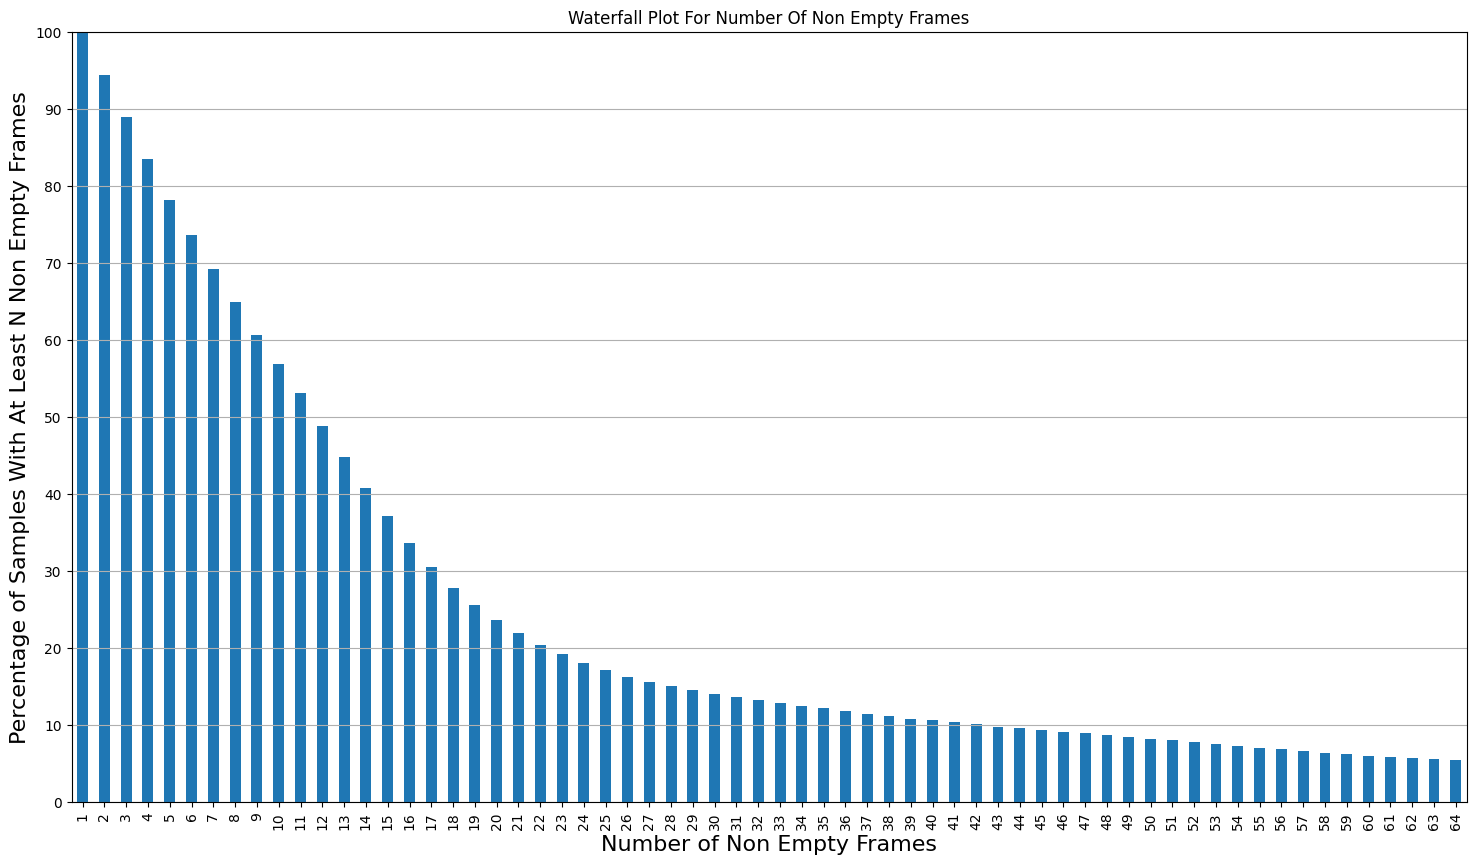

In [21]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

In [22]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 25.20%


#Feature Stats - Left Hands / Pose

In [26]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

In [27]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

In [28]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD



#Model Config

In [29]:

N_DIMS = 3
INPUT_SIZE = 64 
NUM_CLASSES = 250
BATCH_SIZE = 64
N_EPOCHS = 3
BATCH_ALL_SIGNS_N = 4
WD_RATIO = 0.05
label_smooth_tune = 0.25
N_WARMUP_EPOCHS = 0
LR_MAX = 1e-3
VERBOSE = 1
N_COLS = 66
# N_COLS = 26 if Incl_POSE else 21

# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


#Sampling

In [30]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [31]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


#Transformer

In [32]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [33]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

#Landmark Embedding

In [312]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [34]:
#NEW
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

#Embedding

In [313]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([2], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, left_hand0, pose0, non_empty_frame_idxs, training=False):

        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [314]:
class Embedding_noPose(tf.keras.Model):
    def __init__(self):
        super(Embedding_noPose, self).__init__()

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([2], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, left_hand0, non_empty_frame_idxs, training=False):

        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            left_hand_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [35]:
#NEW
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

#Loss Function using Cross Entropy

In [36]:
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smooth)

#Model

In [316]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])

    # LEFT HAND
    LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()
    left_hand = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )

    # Flatten
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])

    if Incl_POSE:
      # POSE
      POSE_MEAN, POSE_STD = get_pose_mean_std()
      pose = tf.slice(x, [0,0,21,0], [-1,INPUT_SIZE, 5, 2])
      pose = tf.where(
              tf.math.equal(pose, 0.0),
              0.0,
              (pose - POSE_MEAN) / POSE_STD,
         )
    
      pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(left_hand, pose, non_empty_frame_idxs) if Incl_POSE else Embedding_noPose()(left_hand, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [37]:
#NEW
LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()
POSE_MEAN, POSE_STD = get_pose_mean_std()

def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [38]:
tf.keras.backend.clear_session()

model = get_model()

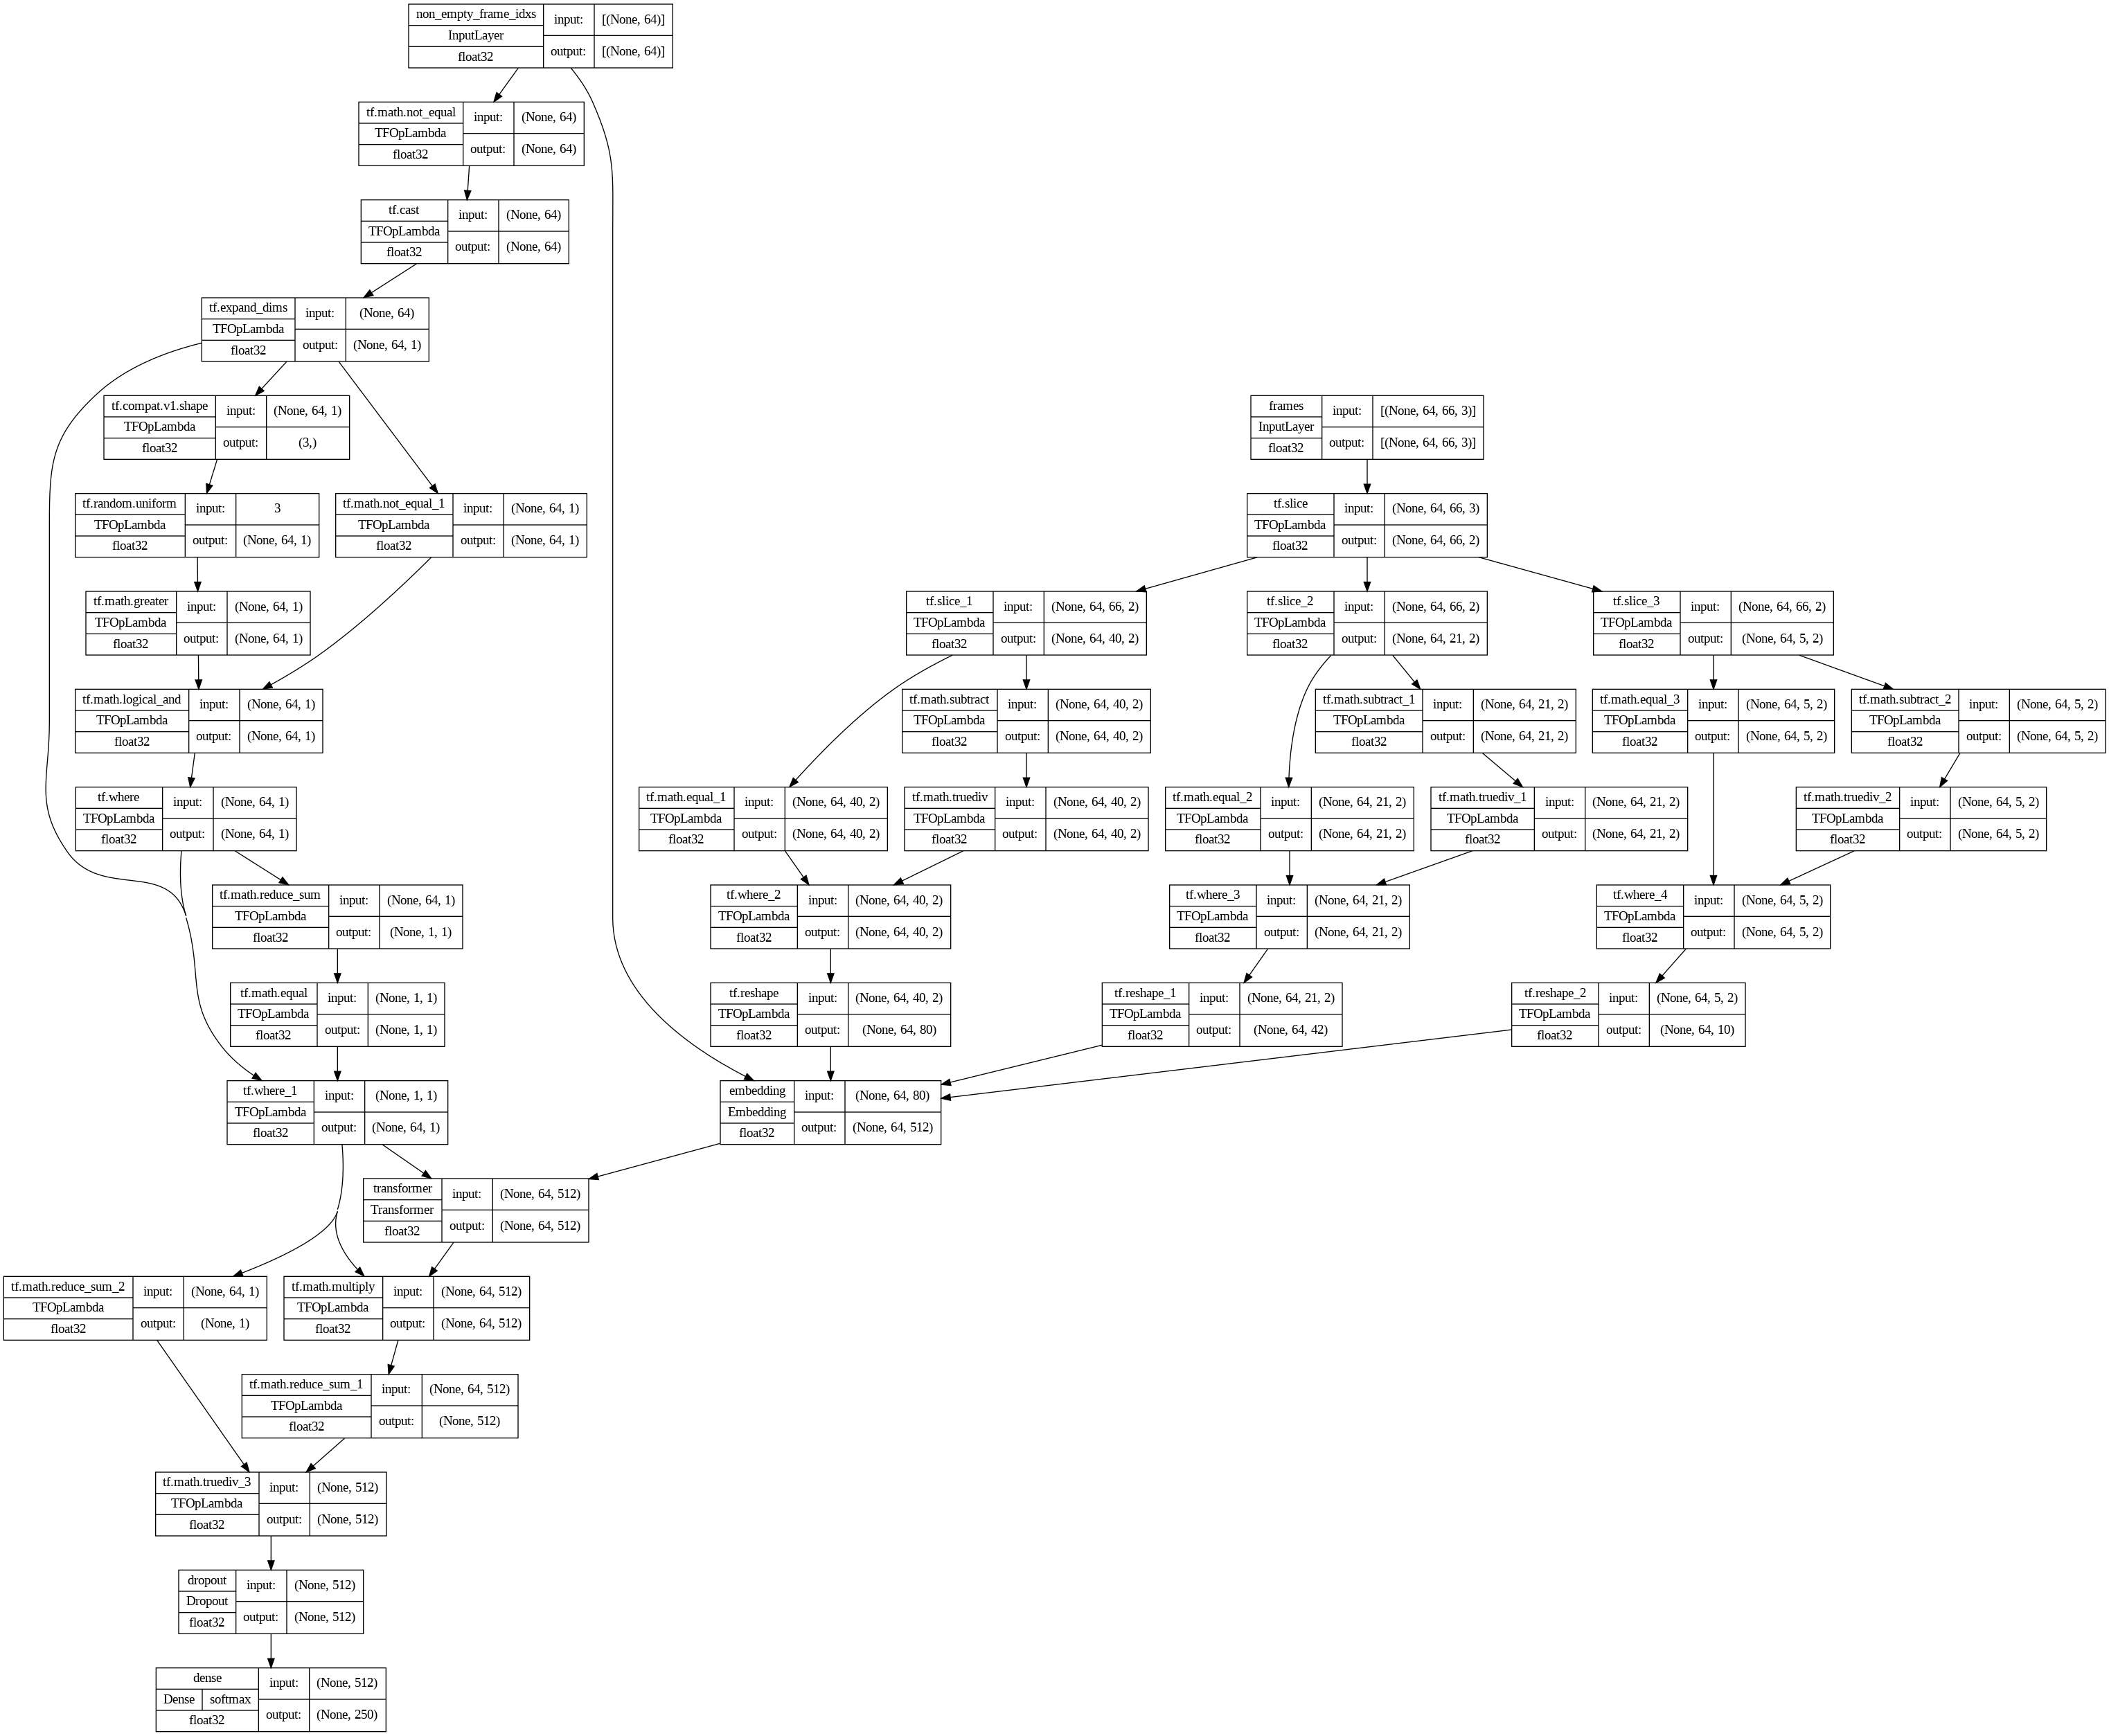

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

In [40]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [41]:
y_pred = model.predict_on_batch(X_batch).flatten()
print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# NaN Values In Prediction: 250000


#Learning Rate Scheduler / Weight Decay Callback

In [416]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [417]:
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [418]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

#Training

In [419]:
def train_eval_model():
    # Clear all models in GPU
    tf.keras.backend.clear_session()
    
    label_smooth = label_smooth_tune
    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch= len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs= N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )
    
    return history

In [421]:
label_smooth = label_smooth_tune
train_eval_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

KeyboardInterrupt: ignored

In [324]:
frank = model.evaluate(*validation_data, verbose=2)

147/147 - 2s - loss: nan - acc: 0.0043 - top_5_acc: 0.0000e+00 - top_10_acc: 0.0000e+00 - 2s/epoch - 15ms/step


In [330]:
y_batch

array([  0,   0,   0,   1,   1,   1,   2,   2,   2,   3,   3,   3,   4,
         4,   4,   5,   5,   5,   6,   6,   6,   7,   7,   7,   8,   8,
         8,   9,   9,   9,  10,  10,  10,  11,  11,  11,  12,  12,  12,
        13,  13,  13,  14,  14,  14,  15,  15,  15,  16,  16,  16,  17,
        17,  17,  18,  18,  18,  19,  19,  19,  20,  20,  20,  21,  21,
        21,  22,  22,  22,  23,  23,  23,  24,  24,  24,  25,  25,  25,
        26,  26,  26,  27,  27,  27,  28,  28,  28,  29,  29,  29,  30,
        30,  30,  31,  31,  31,  32,  32,  32,  33,  33,  33,  34,  34,
        34,  35,  35,  35,  36,  36,  36,  37,  37,  37,  38,  38,  38,
        39,  39,  39,  40,  40,  40,  41,  41,  41,  42,  42,  42,  43,
        43,  43,  44,  44,  44,  45,  45,  45,  46,  46,  46,  47,  47,
        47,  48,  48,  48,  49,  49,  49,  50,  50,  50,  51,  51,  51,
        52,  52,  52,  53,  53,  53,  54,  54,  54,  55,  55,  55,  56,
        56,  56,  57,  57,  57,  58,  58,  58,  59,  59,  59,  6

In [326]:
y_pred = model.predict_on_batch(X_batch)

In [327]:
y_pred.shape

(750, 250)

In [328]:
y_pred[0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [329]:
X_batch['frames'][0].shape

(64, 21, 2)